In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input

seed = 2025
tf.random.set_seed(seed)
np.random.seed(seed)

In [2]:
def _concordance_correlation_coefficient(x, y):
    # https://nirpyresearch.com/concordance-correlation-coefficient/
    ''' Concordance Correlation Coefficient'''
    sxy = np.sum((x - x.mean())*(y - y.mean()))/x.shape[0]
    rhoc = 2*sxy / (np.var(x) + np.var(y) + (x.mean() - y.mean())**2)
    return rhoc

def _compute_metrics(y_true, y_pred):
    pearson_r_arousal = np.corrcoef(y_true[:, 0], y_pred[:, 0])[0, 1]
    pearson_r_valence = np.corrcoef(y_true[:, 1], y_pred[:, 1])[0, 1]
    ccc_arousal = _concordance_correlation_coefficient(y_true[:, 0], y_pred[:, 0])
    ccc_valence = _concordance_correlation_coefficient(y_true[:, 1], y_pred[:, 1])
    return pearson_r_arousal, pearson_r_valence, ccc_arousal, ccc_valence

In [3]:
def generate_baseline_predictions(df: pd.DataFrame, plot: bool=False) -> tuple[list, pd.DataFrame]:
    participants = df["Participant"].unique()
    participants.sort()

    all_results = []
    evaluations = []
    for p in participants:
        print(f"Processing participant {p}:")
        scaler = StandardScaler()

        # leave-one-participant-out setup
        training_participant_ids = participants.tolist()
        training_participant_ids.remove(p)

        # splitting into training and testing
        train_set = df[df["Participant"].isin(training_participant_ids)]
        test_set = df[df["Participant"] == p]

        # splitting features (X) from labels (y)
        X_train = train_set.iloc[:, 3:].values # features (PCs)
        y_train = train_set.iloc[:, :2].values # labels (arousal, valence)

        X_test = test_set.iloc[:, 3:].values
        y_test = test_set.iloc[:, :2].values

        # scale features
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        ########## Linear model: Linear Regression ##########
        print("\t...making predictions: linear regression")
        lr_model = LinearRegression()
        lr_model.fit(X_train_scaled, y_train)
        y_pred_lr = lr_model.predict(X_test_scaled)

        ########## Non-linear model: Random Forest ##########
        print("\t...making predictions: random forest")
        rf_model = RandomForestRegressor(random_state=seed)
        rf_model.fit(X_train_scaled, y_train)
        y_pred_rf = rf_model.predict(X_test_scaled)

        ########## Non-linear model: Neural Network ##########
        print("\t...making predictions: neural network")
        model = Sequential([
            Input(shape=(X_train_scaled.shape[1],)),
            Dense(64, activation="relu", kernel_regularizer=regularizers.l2(0.02)),
            Dense(32, activation="relu", kernel_regularizer=regularizers.l2(0.02)),
            Dense(2, activation="linear")  # linear activation for regression
        ])

        # learning rate schedule
        lr_schedule = ExponentialDecay(
            initial_learning_rate=0.001,
            decay_steps=100000,
            decay_rate=0.96,
            staircase=True
        )

        model.compile(
            optimizer=Adam(learning_rate=lr_schedule),
            loss="mse", # mean squared error for regression
            metrics=["mae"] # mean absolute error as evaluation metric
        )

        early_stopping = EarlyStopping(
            monitor="val_loss", 
            patience=5, 
            restore_best_weights=True
        )

        # train model
        history = model.fit(
            X_train_scaled, y_train, 
            epochs=500, # high max epoch to allow early stopping to determine when to stop
            batch_size=64, 
            validation_split=0.2, # ensures shuffling for validation set
            callbacks=[early_stopping],
            verbose=0
        )

        if plot:
            # plot training & validation loss
            plt.figure(figsize=(6, 3))

            # loss
            plt.subplot(1, 2, 1)
            plt.plot(history.history["loss"], label="Training Loss")
            plt.plot(history.history["val_loss"], label="Validation Loss")
            plt.xlabel("Epochs")
            plt.ylabel("Loss")
            plt.legend()

            # MAE
            plt.subplot(1, 2, 2)
            plt.plot(history.history["mae"], label="Training MAE")
            plt.plot(history.history["val_mae"], label="Validation MAE")
            plt.xlabel("Epochs")
            plt.ylabel("Mean Absolute Error (MAE)")
            plt.legend()

            plt.tight_layout()
            plt.show()

        # evaluate on test set
        test_loss, test_mae = model.evaluate(X_test_scaled, y_test, verbose=0)

        # predictions
        y_pred_nn = model.predict(X_test_scaled, verbose=0)

        # buildup of results dataframe
        temp_df = test_set[["Participant", "median_arousal", "median_valence"]].copy()
        temp_df["lr_prd_arousal"] = y_pred_lr[:, 0]
        temp_df["lr_prd_valence"] = y_pred_lr[:, 1]
        temp_df["rf_prd_arousal"] = y_pred_rf[:, 0]
        temp_df["rf_prd_valence"] = y_pred_rf[:, 1]
        temp_df["nn_prd_arousal"] = y_pred_nn[:, 0]
        temp_df["nn_prd_valence"] = y_pred_nn[:, 1]
        all_results.append(temp_df)

        # compute Pearson r and CCC for each label
        (
            lr_pearson_r_arousal,
            lr_pearson_r_valence,
            lr_ccc_arousal,
            lr_ccc_valence
        ) = _compute_metrics(y_test, y_pred_lr)

        (
            rf_pearson_r_arousal,
            rf_pearson_r_valence,
            rf_ccc_arousal,
            rf_ccc_valence
        ) = _compute_metrics(y_test, y_pred_rf)

        (
            nn_pearson_r_arousal,
            nn_pearson_r_valence,
            nn_ccc_arousal,
            nn_ccc_valence
        ) = _compute_metrics(y_test, y_pred_nn)

        # store results for the participant
        evaluations.append({
            "participant": p,
            "lr_pearson_r_arousal": lr_pearson_r_arousal,
            "lr_pearson_r_valence": lr_pearson_r_valence,
            "lr_ccc_arousal": lr_ccc_arousal,
            "lr_ccc_valence": lr_ccc_valence,
            "rf_pearson_r_arousal": rf_pearson_r_arousal,
            "rf_pearson_r_valence": rf_pearson_r_valence,
            "rf_ccc_arousal": rf_ccc_arousal,
            "rf_ccc_valence": rf_ccc_valence,
            "nn_test_loss": test_loss,
            "nn_test_mae": test_mae,
            "nn_pearson_r_arousal": nn_pearson_r_arousal,
            "nn_pearson_r_valence": nn_pearson_r_valence,
            "nn_ccc_arousal": nn_ccc_arousal,
            "nn_ccc_valence": nn_ccc_valence
        })

    df_with_predictions = pd.concat(all_results, ignore_index=True)

    return evaluations, df_with_predictions

Using visual data:
Processing participant 16:
	...making predictions: linear regression
	...making predictions: random forest
	...making predictions: neural network


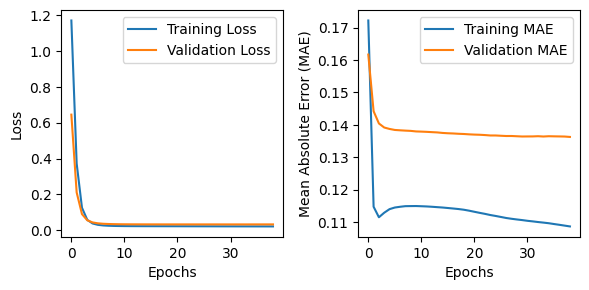

Processing participant 19:
	...making predictions: linear regression
	...making predictions: random forest
	...making predictions: neural network


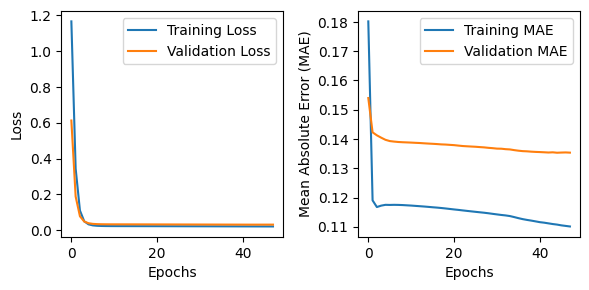

Processing participant 21:
	...making predictions: linear regression
	...making predictions: random forest
	...making predictions: neural network


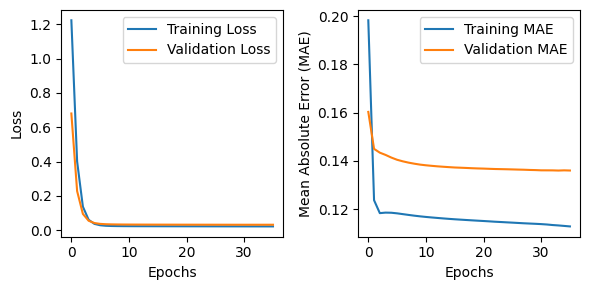

Processing participant 23:
	...making predictions: linear regression
	...making predictions: random forest
	...making predictions: neural network


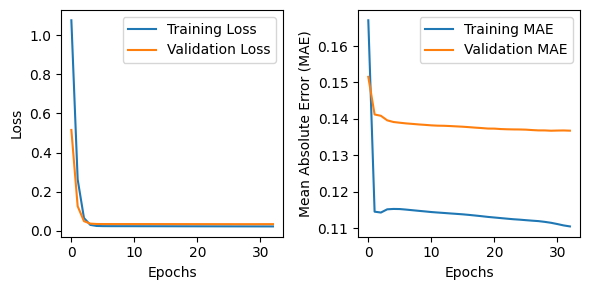

Processing participant 25:
	...making predictions: linear regression
	...making predictions: random forest
	...making predictions: neural network


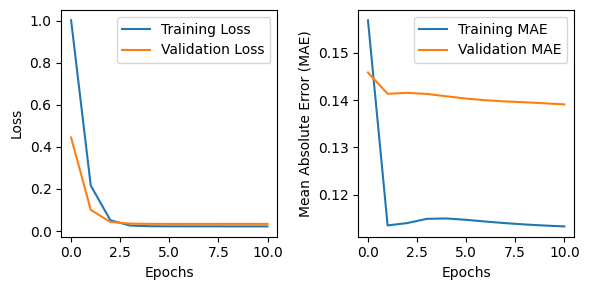

Processing participant 26:
	...making predictions: linear regression
	...making predictions: random forest
	...making predictions: neural network


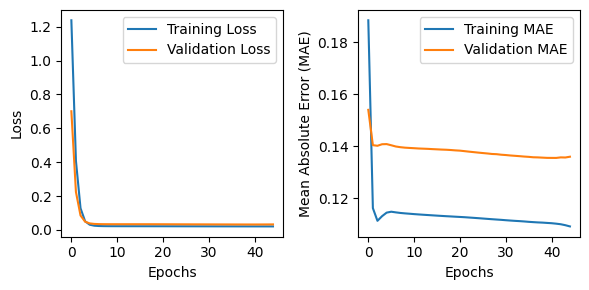

Processing participant 28:
	...making predictions: linear regression
	...making predictions: random forest
	...making predictions: neural network


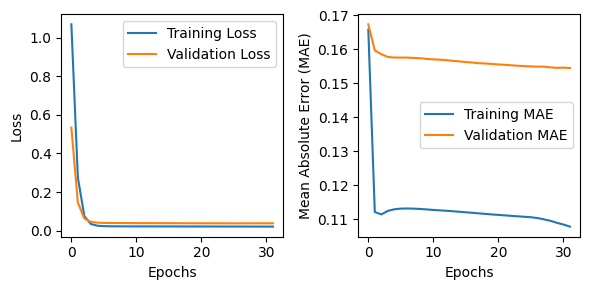

Processing participant 30:
	...making predictions: linear regression
	...making predictions: random forest
	...making predictions: neural network


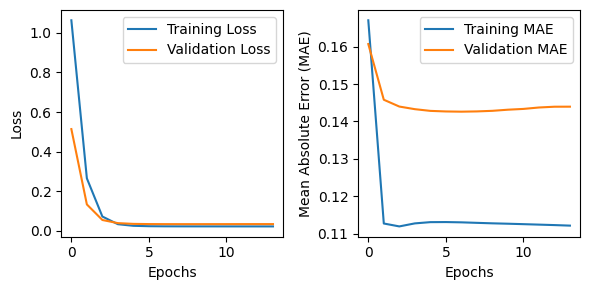

Processing participant 34:
	...making predictions: linear regression
	...making predictions: random forest
	...making predictions: neural network


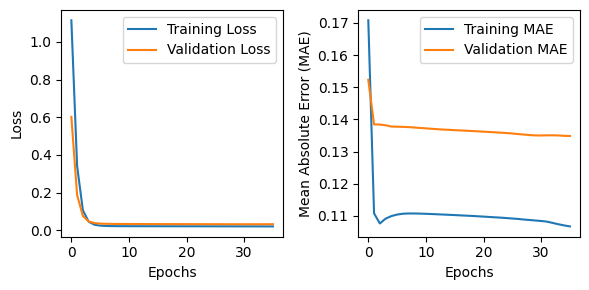

Processing participant 37:
	...making predictions: linear regression
	...making predictions: random forest
	...making predictions: neural network


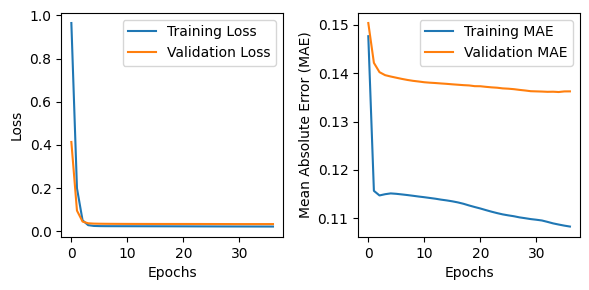

Processing participant 39:
	...making predictions: linear regression
	...making predictions: random forest
	...making predictions: neural network


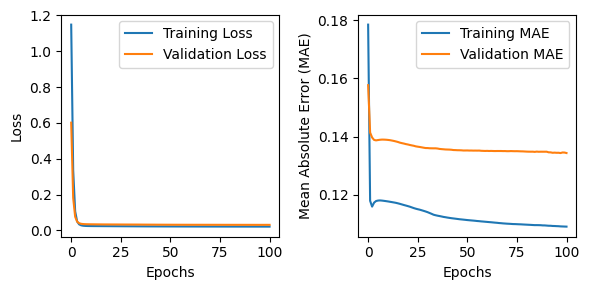

Processing participant 41:
	...making predictions: linear regression
	...making predictions: random forest
	...making predictions: neural network


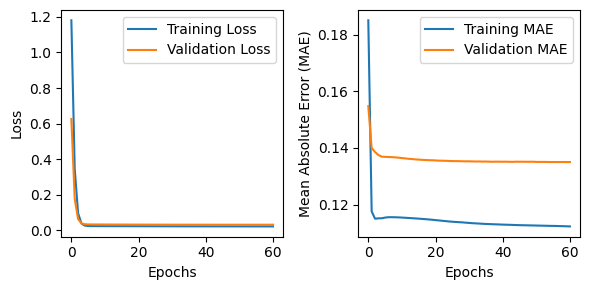

Processing participant 42:
	...making predictions: linear regression
	...making predictions: random forest
	...making predictions: neural network


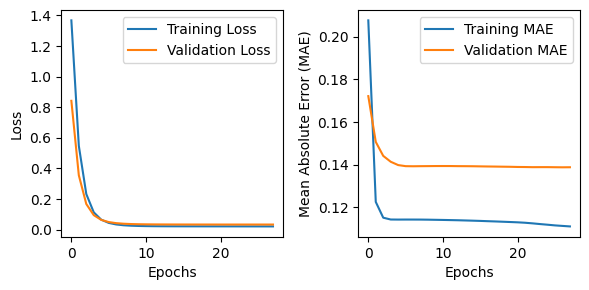

Processing participant 45:
	...making predictions: linear regression
	...making predictions: random forest
	...making predictions: neural network


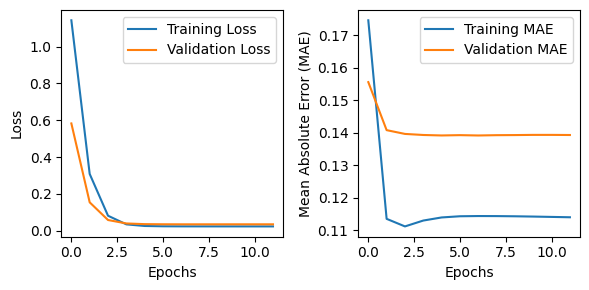

Processing participant 46:
	...making predictions: linear regression
	...making predictions: random forest
	...making predictions: neural network


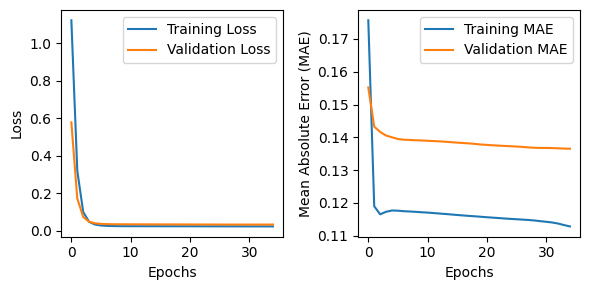

Processing participant 56:
	...making predictions: linear regression
	...making predictions: random forest
	...making predictions: neural network


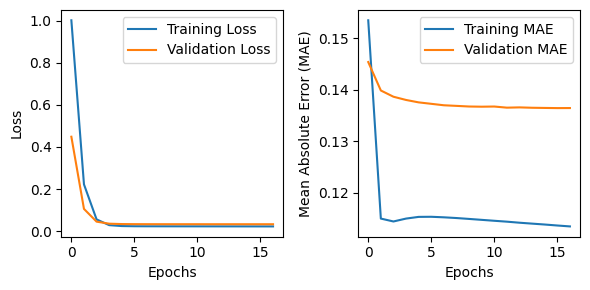

Processing participant 64:
	...making predictions: linear regression
	...making predictions: random forest
	...making predictions: neural network


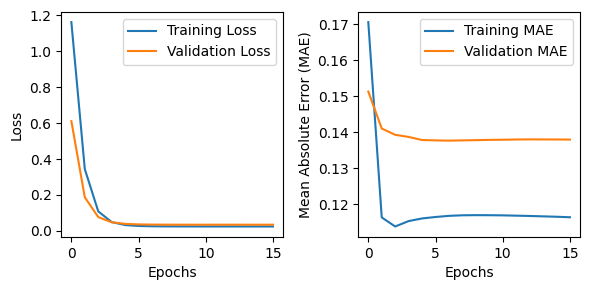

Processing participant 65:
	...making predictions: linear regression
	...making predictions: random forest
	...making predictions: neural network


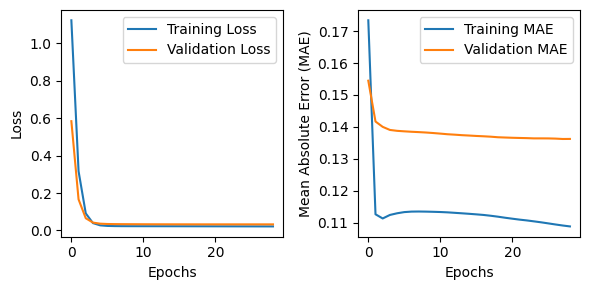

Using audio data:
Processing participant 16:
	...making predictions: linear regression
	...making predictions: random forest
	...making predictions: neural network
Processing participant 19:
	...making predictions: linear regression
	...making predictions: random forest
	...making predictions: neural network
Processing participant 21:
	...making predictions: linear regression
	...making predictions: random forest
	...making predictions: neural network
Processing participant 23:
	...making predictions: linear regression
	...making predictions: random forest
	...making predictions: neural network
Processing participant 25:
	...making predictions: linear regression
	...making predictions: random forest
	...making predictions: neural network
Processing participant 26:
	...making predictions: linear regression
	...making predictions: random forest
	...making predictions: neural network
Processing participant 28:
	...making predictions: linear regression
	...making predictions: random forest

In [4]:
modalities = ["visual", "audio", "physio"]

# creating a single dataframe containing actual values and all predictions
prediction_dfs = []
all_evals = []
single_plot_indicator = True
for modality in modalities:
    print(f"Using {modality} data:")
    modality_df = pd.read_csv(f"../data/subset_{modality}_pca.csv")
    evaluations, df_with_predictions = generate_baseline_predictions(modality_df, plot=single_plot_indicator)
    evaluations = [
        {
            (f"{modality}_" + key if key != "participant" else key): value
            for key, value in evaluation.items()
        }
        for evaluation in evaluations
    ]
    all_evals.extend(evaluations)
    # rename prediction columns accoring to modality
    df_with_predictions.columns = df_with_predictions.columns.str.replace("prd", modality)
    prediction_dfs.append(df_with_predictions)
    single_plot_indicator = False

# merge all predictions
all_predicitons_df = pd.concat(prediction_dfs, axis=1)
all_predicitons_df = all_predicitons_df.loc[:, ~all_predicitons_df.columns.duplicated()]
all_predicitons_df.to_csv("../results/data_with_predictions_baseline.csv", index=False)

all_evals_df = pd.DataFrame(all_evals)
all_evals_df = all_evals_df.groupby("participant").first()
all_evals_df.to_csv("../results/baseline_evaluations.csv")